In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

import tensorflow as tf

from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils, to_categorical, pad_sequences
import keras 
from keras.datasets import imdb

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
### Load the data
(train_samples, train_labels), (test_samples, test_labels) = imdb.load_data(num_words=10000)

In [4]:
# A dictionary mapping words to an integer index
vocabulary = imdb.get_word_index()

# The first indices are reserved
vocabulary = {k:(v+3) for k,v in vocabulary.items()} 
vocabulary["<PAD>"] = 0
# See how integer 1 appears first in the review above. 
vocabulary["<START>"] = 1
vocabulary["<UNK>"] = 2  # unknown
vocabulary["<UNUSED>"] = 3

# reversing the vocabulary. 
# in the index, the key is an integer, 
# and the value is the corresponding word.
index = dict([(value, key) for (key, value) in vocabulary.items()])

# reversing the vocabulary. 
# in the index, the key is an integer, 
# and the value is the corresponding word.

def decode_review(text):
    '''converts encoded text to human readable form.
    each integer in the text is looked up in the index, and 
    replaced by the corresponding word.
    '''
    return ' '.join([index.get(i, '?') for i in text])

decode_review(train_samples[2])


"<START> this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had <UNK> working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how <UNK> this is to watch save yourself an hour a bit of your life"

### Preprocess 

In [5]:
# PAD the sequences to the same length
# Padding is necessary because the input data must be a uniform length.
# It consists of adding a special character to the end of the sequence until it reaches the desired length.

train_data = tf.keras.preprocessing.sequence.pad_sequences(train_samples,
                                                        value=vocabulary["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = tf.keras.preprocessing.sequence.pad_sequences(test_samples,
                                                       value=vocabulary["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [6]:
# Set a VALIDATION set
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

# Set a VALIDATION set

x_val = train_data[:10000]
partial_x_train = train_data[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

x_test = test_data
print("x_val ", x_val.shape)
print("partial_x_train ", partial_x_train.shape)
print("y_val ", y_val.shape)
print("partial_y_train ", partial_y_train.shape)


print("x_test ", x_test.shape)
print("y_test ", y_test.shape)

y_train  (25000,)
y_test  (25000,)
x_val  (10000, 256)
partial_x_train  (15000, 256)
y_val  (10000,)
partial_y_train  (15000,)
x_test  (25000, 256)
y_test  (25000,)


In [7]:
len(vocabulary)

88588

### Model Implim

In [8]:
model = keras.Sequential()
# The Embedding layer takes at least two arguments:
# the number of possible tokens, here 88588 and input_length, the length of the input sequences, here 256.
model.add(keras.layers.Embedding(len(vocabulary), 2, input_length=256))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(5))
model.add(keras.layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 256, 2)            177176    
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 5)                 2565      
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 179,747
Trainable params: 179,747
Non-trainable params: 0
_________________________________________________________________


In [9]:
from keras.callbacks import EarlyStopping

# Epochs and Batch Size 
# Epochs is the number of times the model is exposed to the training dataset.
# Batch Size is the number of samples per gradient update for training.
NumEpochs = 50
BatchSize = 100

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# define early stopping criteria
earlystop = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=10, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(partial_x_train , partial_y_train, epochs=NumEpochs, batch_size=BatchSize, validation_data=(x_val, y_val), callbacks=[earlystop])


Epoch 1/50
150/150 [==============================] - 3s 13ms/step - loss: 0.6930 - acc: 0.5141 - val_loss: 0.6917 - val_acc: 0.5284
Epoch 2/50
150/150 [==============================] - 2s 14ms/step - loss: 0.6585 - acc: 0.6402 - val_loss: 0.5839 - val_acc: 0.7355
Epoch 3/50
150/150 [==============================] - 2s 11ms/step - loss: 0.4530 - acc: 0.8052 - val_loss: 0.3723 - val_acc: 0.8528
Epoch 4/50
150/150 [==============================] - 2s 10ms/step - loss: 0.3218 - acc: 0.8705 - val_loss: 0.3179 - val_acc: 0.8697
Epoch 5/50
150/150 [==============================] - 2s 12ms/step - loss: 0.2760 - acc: 0.8874 - val_loss: 0.3004 - val_acc: 0.8757
Epoch 6/50
150/150 [==============================] - 2s 12ms/step - loss: 0.2395 - acc: 0.9045 - val_loss: 0.2896 - val_acc: 0.8831
Epoch 7/50
150/150 [==============================] - 2s 10ms/step - loss: 0.2188 - acc: 0.9129 - val_loss: 0.2851 - val_acc: 0.8840
Epoch 8/50
150/150 [==============================] - 2s 11ms/step - 

### Model eval 

In [10]:
results = model.evaluate(x_test, y_test)
print("_"*100)
print("Test Loss and Accuracy")
print("results ", results)
history_dict = history.history
history_dict.keys()

782/782 [==============================] - 4s 4ms/step - loss: 0.3036 - acc: 0.8728
____________________________________________________________________________________________________
Test Loss and Accuracy
results  [0.30357030034065247, 0.872759997844696]


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

782/782 [==============================] - 3s 3ms/step


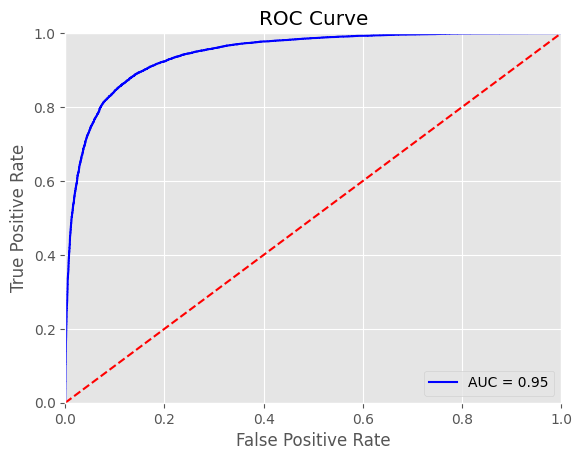

In [11]:
import sklearn.metrics as metrics

y_pred = model.predict(x_test)
y_pred_proba = y_pred.ravel()  # Reshape to 1-dimensional array
# Make predictions on the test set
y_pred = model.predict(x_test)
y_test = y_test.ravel()  # Reshape to 1-dimensional array

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)

# Calculate the area under the ROC curve (AUC)
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC curve
import matplotlib.pyplot as plt
plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


782/782 [==============================] - 3s 4ms/step


<Axes: >

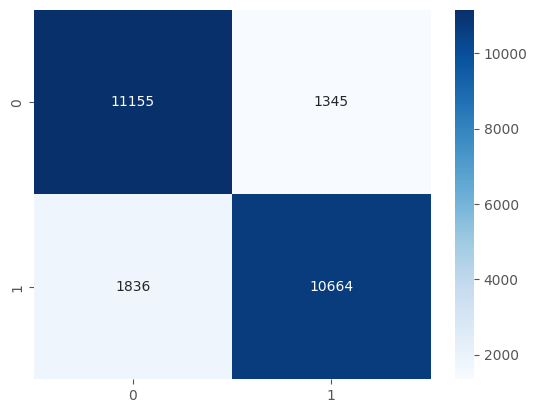

In [12]:
# Confusion matrix 

y_test_predictions = model.predict(x_test)
y_test_predictions = (y_test_predictions > 0.5)

conf_matrix = confusion_matrix(y_test, y_test_predictions)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

### Test on new review written by us

In [16]:
# Take 5 input reviews 
reviews = []
for i in range(5):
    review = input("Enter review " + str(i+1) + ": ")
    reviews.append(review)

# Convert the reviews to sequences of integers using the word index
review_seqs = []
for review in reviews:
    review_seq = [vocabulary.get(word, vocabulary["<UNK>"]) for word in review.lower().split()]
    review_seqs.append(review_seq)

# Pad the sequences to the same length as the training data
review_seqs_padded = tf.keras.preprocessing.sequence.pad_sequences(review_seqs,
                                                                    value=vocabulary["<PAD>"],
                                                                    padding='post',
                                                                    maxlen=256)

# Make predictions using the trained model
predictions = model.predict(review_seqs_padded)

# Convert the predictions to human-readable labels
sentiments = []
for prediction in predictions:
    sentiment = "positive" if prediction[0] > 0.5 else "negative"
    sentiments.append(sentiment)

# Print the input review and its predicted sentiment
for i in range(5):
    print(f"The sentiment of review '{reviews[i]}' is {sentiments[i]}.")


1/1 [==============================] - 0s 75ms/step
The sentiment of review 'This movie was terrible! The acting was wooden and the plot was nonsensical. I regret wasting my time and money on it' is negative.
The sentiment of review 'I had high hopes for this movie, but it was a huge disappointment. The pacing was slow and the characters were uninteresting. Save yourself the trouble and skip this one.' is negative.
The sentiment of review 'I absolutely loved this movie! The performances were outstanding and the story was gripping from start to finish. I can't wait to see it again." Positive review: "This movie was a breath of fresh air! It was funny, heartwarming, and thought-provoking all at once. I left the theater feeling uplifted and inspired' is positive.
The sentiment of review 'I was blown away by this movie! The cinematography was stunning and the music was hauntingly beautiful. The acting was also top-notch. I highly recommend it to anyone who appreciates great storytelling' i

['This movie was terrible! The acting was wooden and the plot was nonsensical. I regret wasting my time and money on it',
 'I had high hopes for this movie, but it was a huge disappointment. The pacing was slow and the characters were uninteresting. Save yourself the trouble and skip this one.',
 'I absolutely loved this movie! The performances were outstanding and the story was gripping from start to finish. I can\'t wait to see it again." Positive review: "This movie was a breath of fresh air! It was funny, heartwarming, and thought-provoking all at once. I left the theater feeling uplifted and inspired',
 'I was blown away by this movie! The cinematography was stunning and the music was hauntingly beautiful. The acting was also top-notch. I highly recommend it to anyone who appreciates great storytelling',
 'Although the plot was interesting, the execution was poor. The pacing was slow and the acting was wooden. However, the cinematography was beautiful and some scenes were visually

### GLOVE

In [22]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten, GlobalMaxPooling1D, Conv1D
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils, to_categorical, pad_sequences
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# Load the data
(train_samples, train_labels), (test_samples, test_labels) = imdb.load_data(num_words=10000)

# Convert the data back into text for tokenization
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
decoded_train_samples = [' '.join([reverse_word_index.get(i - 3, '?') for i in sample]) for sample in train_samples]
decoded_test_samples = [' '.join([reverse_word_index.get(i - 3, '?') for i in sample]) for sample in test_samples]

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(decoded_train_samples)
sequences_train = tokenizer.texts_to_sequences(decoded_train_samples)
sequences_test = tokenizer.texts_to_sequences(decoded_test_samples)

# Pad the sequences to the same length
train_data = pad_sequences(sequences_train, maxlen=256)
test_data = pad_sequences(sequences_test, maxlen=256)

# Prepare the labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

# Load the pre-trained GloVe embeddings
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.word2vec.txt'
glove2word2vec(glove_input_file, word2vec_output_file)
embeddings_index = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

# Create the embedding matrix
embedding_matrix = np.zeros((10000, 100))
for word, i in tokenizer.word_index.items():
    if i >= 10000:
        continue
    try:
        embedding_vector = embeddings_index[word]
    except KeyError:
        embedding_vector = None
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the model architecture
model = Sequential()
model.add(Embedding(10000, 100, input_length=256))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Set the embedding matrix for the Embedding layer
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Compile and train the model
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_accuracy', patience=10)
history = model.fit(train_data, y_train, epochs=50, batch_size=512, validation_data=(test_data, y_test), callbacks=[early_stop])

# Evaluate the model on the test set
results = model.evaluate(test_data, y_test)
print('Test accuracy:', results[1])


In [ ]:
# Other implim trying to find the best parameters
model = Sequential()
model.add(Embedding(10000, 100, input_length=256))
model.add(Conv1D(32, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
